In [38]:
import json
import sys
from scipy.interpolate import CubicSpline
from scipy.optimize import root_scalar

import fipy as fp
from fipy import numerix as nmx

In [2]:
sys.argv

['/Users/guyer/mambaforge-arm/envs/fipy311/lib/python3.11/site-packages/ipykernel_launcher.py',
 '-f',
 '/Users/guyer/Library/Jupyter/runtime/kernel-45a37b1f-3165-4a50-9bac-55dce0fbff41.json']

In [115]:
if False:
    params = json.load()
else:
    params = {
        "dx": 0.1,
        "Lx": 96.,
        "r0": 8.,
        "dt": 0.5,
        "t_max": 100,
        "output": "dx=0_1dt=0_5.csv",
        "view": False
    }

In [79]:
mesh = fp.Grid1D(dx=params["dx"], Lx=params["Lx"])

In [80]:
u = fp.CellVariable(mesh=mesh, name="u", hasOld=True)

In [81]:
phi = fp.CellVariable(mesh=mesh, name=r"$\varphi$", hasOld=True)

In [82]:
r = nmx.sqrtDot(mesh.cellCenters, mesh.cellCenters)

In [83]:
D = 10.
tau0 = 1.
W0 = 1.
lamda = D * tau0 / (0.6267 * W0**2)
norm = phi.grad / (phi.grad.mag + (phi.grad.mag == 0.) * 1.)
theta = fp.Variable(0.)
theta.name = r"$\theta$"
m = fp.Variable(4)
epsilon = fp.Variable(0.05)
a = 1 + epsilon * nmx.cos(m * theta)
aPrime = -epsilon * nmx.sin(m * theta) * m
tau = tau0 * a**2
W = W0 * a
Wprime = W0 * aPrime
Dphi = W**2
Delta = fp.Variable(value=0.3, name=r"$\Delta$")

In [84]:
u.constrain(-Delta, where=mesh.facesRight)

In [85]:
m.value = 4

In [86]:
ueq = (fp.TransientTerm(coeff=1., var=u) 
       == fp.DiffusionTerm(coeff=D, var=u)
       + fp.TransientTerm(coeff=0.5, var=phi))

In [87]:
phieq = (fp.TransientTerm(coeff=tau, var=phi)
         == fp.DiffusionTerm(coeff=Dphi, var=phi)
         + fp.ImplicitSourceTerm(coeff=1-phi**2, var=phi)
         - fp.ImplicitSourceTerm(coeff=lamda * (1 - 2*phi**2 + phi**4), var=u))

In [88]:
eq = ueq & phieq

In [103]:
f_chem = (-(1/2) * phi**2 + (1/4) * phi**4
          + lamda * u * phi * (1 - (2/3) * phi**2 + (1/5) * phi**4))
free_energy = ((1/2) * W**2 * phi.grad.mag**2 + f_chem).cellVolumeAverage * nmx.sum(mesh.cellVolumes)
solid_fraction = ((phi + 1) / 2).cellVolumeAverage

In [129]:
class TipVariable(fp.Variable):
    def __init__(self, var):
        fp.Variable.__init__(self)
        self.var = self._requires(var)

    def _calcValue(self):
        spl = interpolate.CubicSpline(self.var.mesh.x.value, self.var.value)
        sol = root_scalar(spl, bracket=(0, params["Lx"]))
        if sol.converged:
            return sol.root
        else:
            raise Exception

tip_position = TipVariable(phi)

In [104]:
faceNorm = phi.faceGrad / (phi.faceGrad.mag + (phi.faceGrad.mag == 0.) * 1.)
faceNorm.name = r"$\hat{n}$"
curvature = faceNorm.divergence
curvature.name = r"$\kappa$"

In [105]:
radius = 1. / curvature
radius.name = r"$\rho$"

<Figure size 640x480 with 0 Axes>

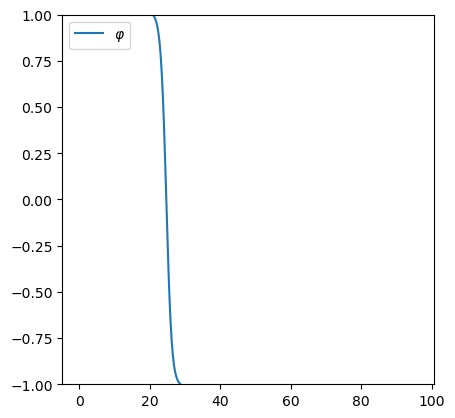

In [106]:
if params["view"]:
    phiviewer = fp.Viewer(vars=phi, datamin=-1, datamax=1)

In [107]:
# radviewer = fp.Viewer(vars=radius *(1 + phi) * (1-phi), datamin=-20, datamax=0)

In [108]:
# radviewer.plot()

In [109]:
# fp.tools.dump.write(mesh, "mesh.gz")

In [130]:
t = 0.
phi.value = -1
phi.setValue(+1, where=r <= params["r0"])
u.value = -Delta

In [131]:
with open(params["output"], "w") as f:
    f.write(f"t,free_energy,solid_fraction,tip_position\n")
    f.write(f"{t},{free_energy},{solid_fraction},{tip_position}\n")
while t < params["t_max"]:
    phi.updateOld()
    u.updateOld()
    for sweep in range(3):
        res = eq.sweep(dt=params["dt"])
    t += params["dt"]
    if params["view"]:
        phiviewer.plot()
    spl = interpolate.CubicSpline(mesh.x.value, phi.value)
    sol = root_scalar(spl, bracket=(0, params["Lx"]))
    with open(params["output"], "a") as f:
        f.write(f"{t},{free_energy},{solid_fraction},{tip_position}\n")